## Settings

In [1]:
import sys
sys.path.insert(0, "/global/homes/c/cinlima/NumCosmo/notebooks/richness_proxy/")

#NumCosmo
from numcosmo_py import Ncm, Nc, GObject
from richness_mass_calib import create_richness_mass_calib

#Useful packages
import numpy as np
import math
from scipy import stats

from astropy.io import fits
from astropy.table import Table
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

Ncm.cfg_init()
Ncm.cfg_set_log_handler(lambda msg: sys.stdout.write(msg) and sys.stdout.flush())

## Data

In [2]:
# DC2 data
DC2_halos_m200c = fits.open(
    "/global/cfs/projectdirs/lsst/groups/CL/cosmoDC2_v1.1.4/extragal/full/halos/halos_m200c_13.0.fits")

dt_halos = Table(DC2_halos_m200c[1].data)

lnM = np.log(dt_halos["m200c"])  # ln(mass)
z = dt_halos["redshift_true"]  # redshift
lnR = np.log(dt_halos["richness"])  # ln(richness)



## Bins

Nestas células fazemos um recorte de intervalos de z de largura 0.05 e esses intervalos são colocados em **halos_bin_z**. Depois, pegamos cada *bin* em z e cortamos em intervalos de lnM de largura 0.25. Os bins são colocados em **halos_bin_mz**.

Para cada intervalo em **halos_bin_mz** é calculado lnR médio, z médio e lnM médio e as listas desses valores são colocadas na tabela **halos mean**.

In [3]:
# redshift bins
z_0 = 0.0
z_1 = 0.05
halos_bin_z =[]

for i in range(61):
    cut_z = np.logical_and (dt_halos['redshift_true'] > z_0, dt_halos['redshift_true'] < z_1)
    halos_bin_z.append(dt_halos[cut_z])
    z_0 = z_0 + 0.05
    z_1 = z_1 + 0.05

# mass bins
label = []
halos_bin_mz =[]
for i in range(61):
    
    lnM_0 = min(lnM)
    lnM_1 = min(lnM) + 0.25
    for j in range(21):
        
        cut = np.logical_and (np.log(halos_bin_z[i]["m200c"]) > lnM_0, np.log(halos_bin_z[i]["m200c"]) < lnM_1)
        halos_bin_mz.append(halos_bin_z[i][cut])
        label.append(f"{min(halos_bin_z[i]['redshift_true']):.3f} < z < {max(halos_bin_z[i]['redshift_true']):.3f}\n{lnM_0:.3f} < lnM < {lnM_1:.3f}")
        
        lnM_0 = lnM_0 + 0.25
        lnM_1 = lnM_1 + 0.25
        
len(halos_bin_mz)

1281

In [4]:
lnM_binned, z_binned, lnR_binned = [], [], []

for i in range(len(halos_bin_mz)):
    
    halos = halos_bin_mz[i]
    lnM_binned.append(np.log(halos["m200c"]))
    z_binned.append(halos["redshift_true"])
    lnR_binned.append(np.log(halos["richness"]))   

lnR_mean, lnM_mean, z_mean = [np.mean(l) for l in lnR_binned if len(l) > 0], [np.mean(l) for l in lnM_binned if len(l) > 0], [np.mean(k) for k in z_binned if len(k) > 0]

halos_mean = Table([np.exp(np.array(lnR_mean)), np.exp(np.array(lnM_mean)), z_mean],
           names=('richness', 'm200c', 'redshift_true'))

len(lnM_binned)

1281

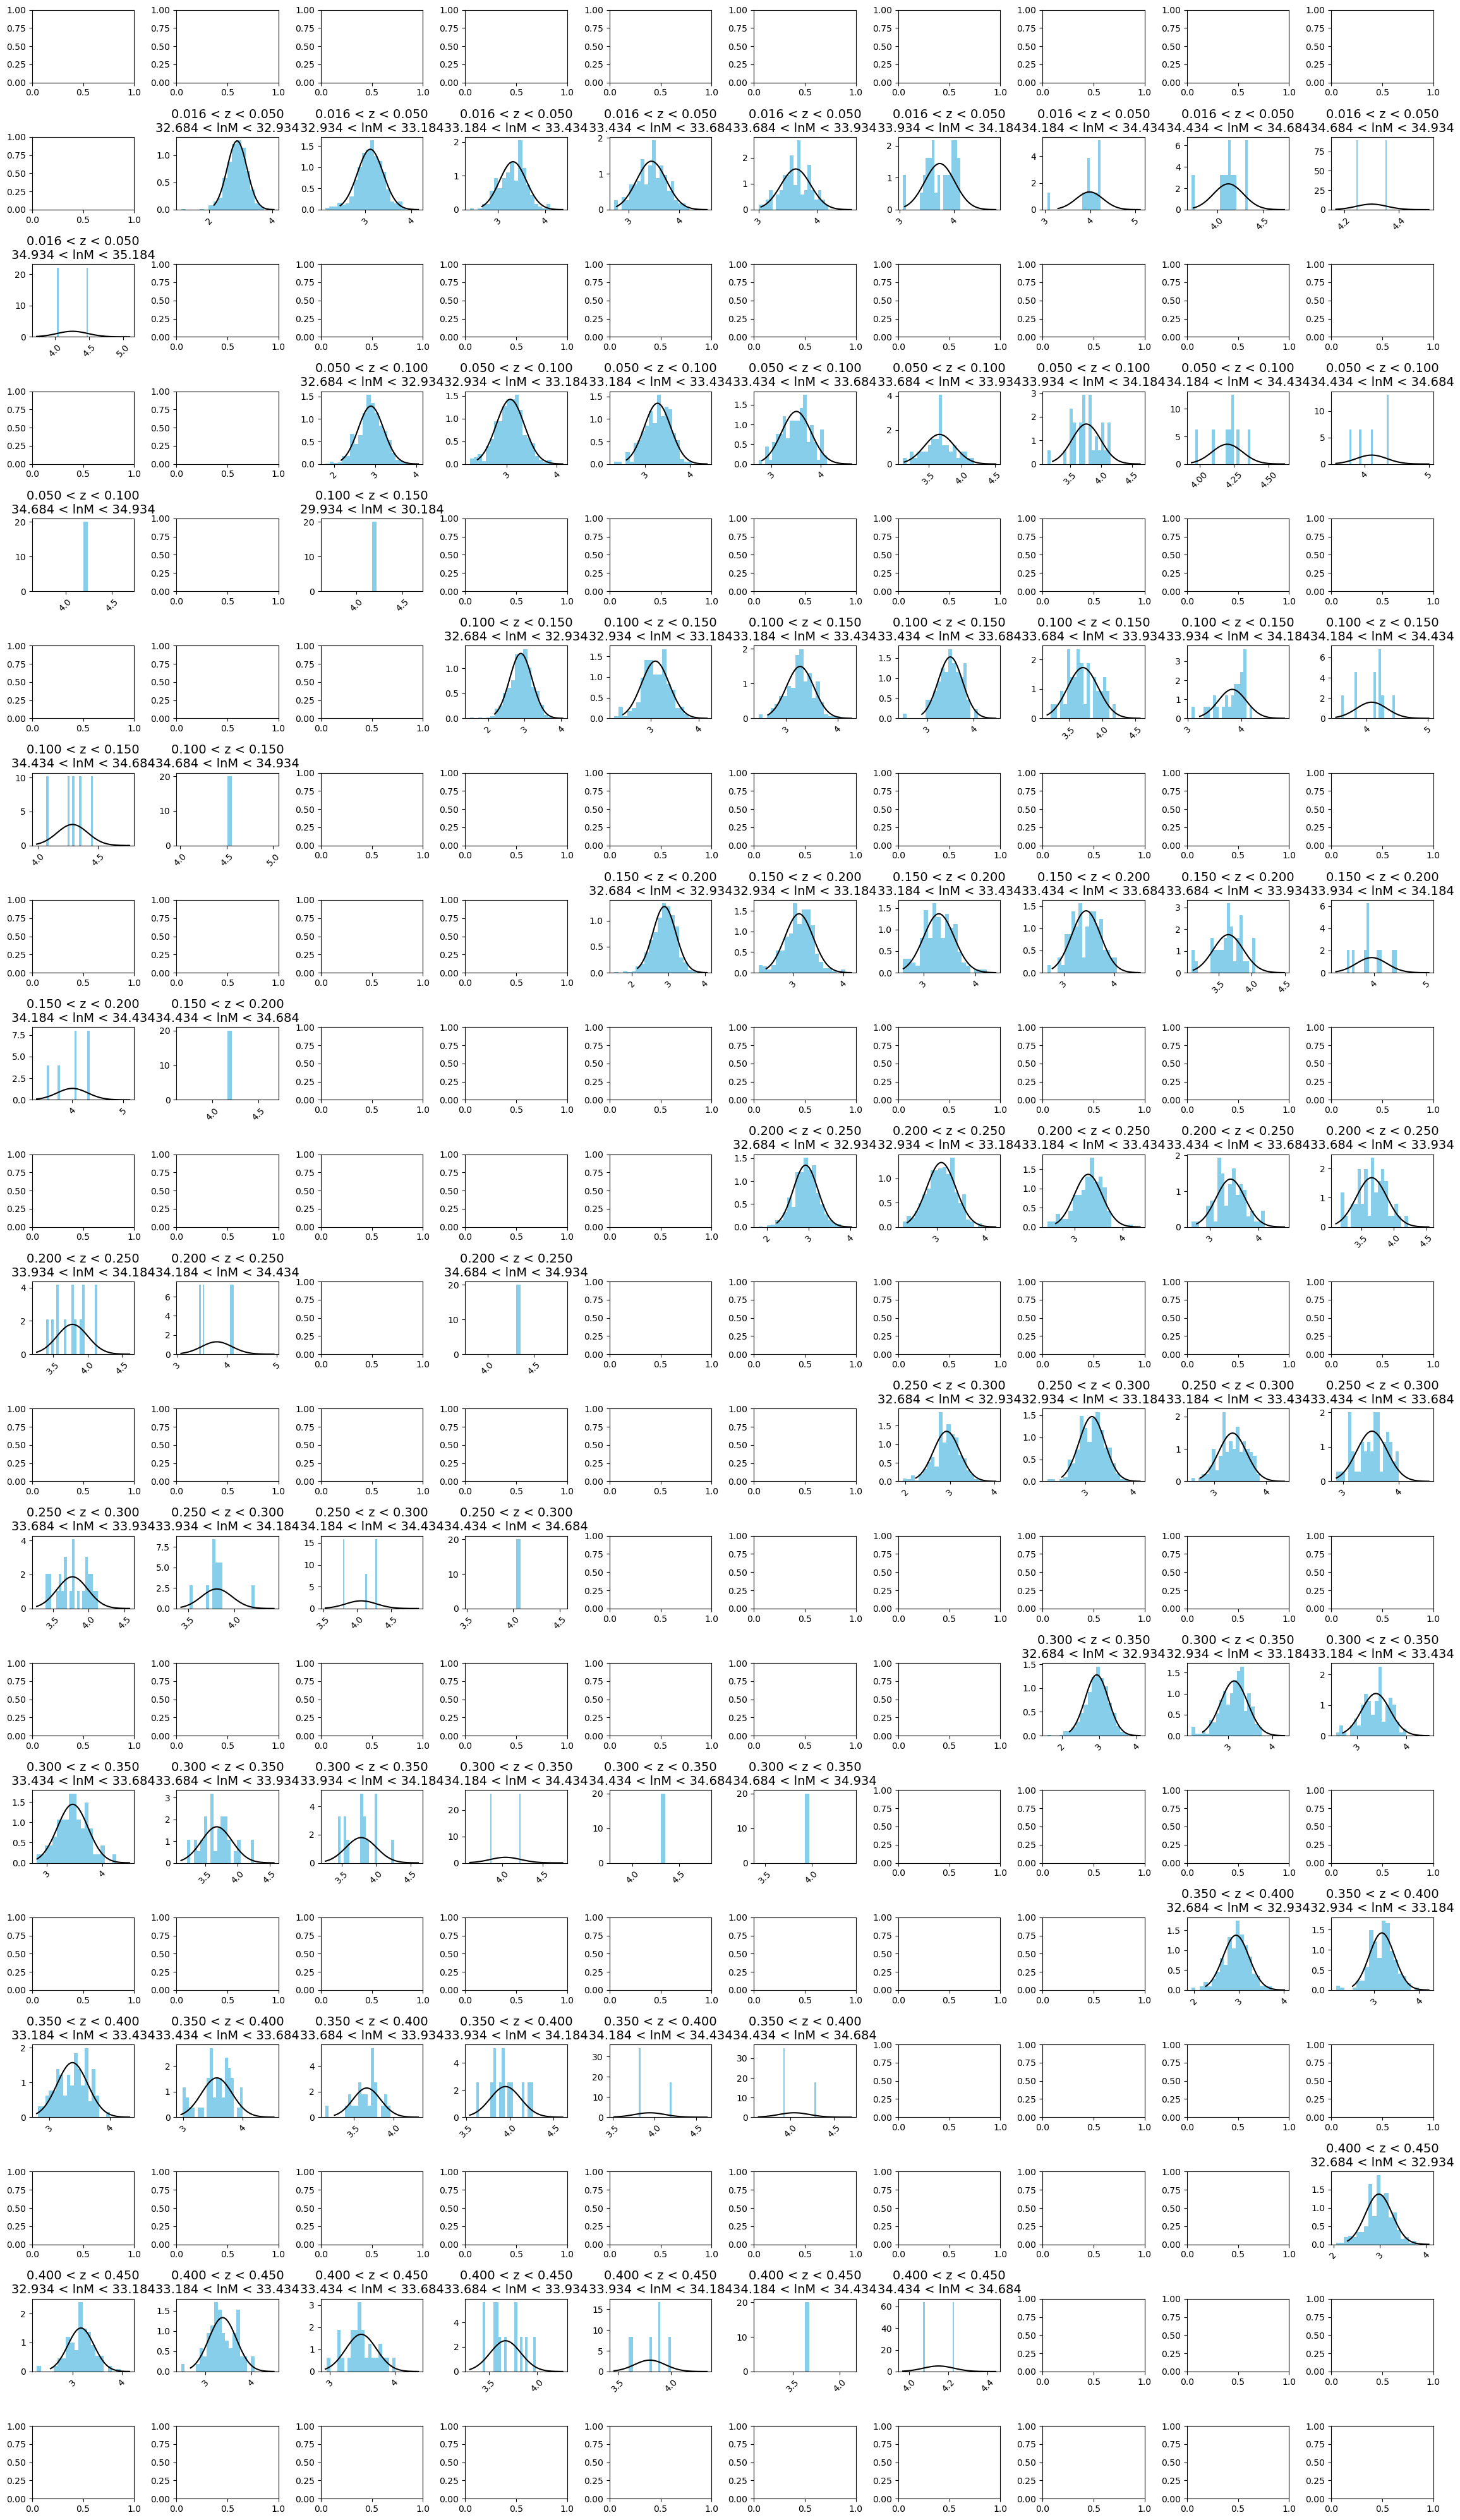

In [11]:
fig, axs = plt.subplots(nrows=20, ncols=10,figsize=(23,40))


for lnR_i, ax, i in zip(lnR_binned[1081:], axs.flat, range(200)):
    
    if len(lnR_i) == 0:
        pass
    
    else:
        points = np.linspace(stats.norm.ppf(0.01,loc=np.mean(lnR_i),scale=np.std(lnR_i)),
                     stats.norm.ppf(0.9999,loc=np.mean(lnR_i),scale=np.std(lnR_i)),100)


        ax.hist(lnR_i, bins=20, density=True, color='skyblue')
        ax.plot(points, stats.norm.pdf(points, np.mean(lnR_i), np.std(lnR_i)), color='black')

        ax.tick_params(axis='x', labelrotation = 45)
        ax.set_title(label[i],fontsize=14)

fig.title('Histogramas dos 200 primeiros intevalos de lnR', fontsize=20)

fig.tight_layout()


#plt.savefig('lnR_bins_0-200.png', format='png')

# Normality test

In [15]:
p_value_res_SW=[]
p_value_res_KS=[]

for lnR_i in lnR_binned:
    
    if len(lnR_i) < 5:
        pass
    
    elif len(lnR_i) > 50:
        pvalue=stats.kstest(lnR_i, stats.norm.cdf, args=(np.mean(lnR_i), np.std(lnR_i))).pvalue
        p_value_res_KS.append(pvalue)
        
    else:
        pvalue=stats.shapiro(lnR_i).pvalue
        p_value_res_SW.append(pvalue)

porc_SW = len([p for p in p_value_res_SW if p > 0.05]) / len(p_value_res_SW)   * 100
porc_KS = len([p for p in p_value_res_KS if p > 0.05]) / len(p_value_res_KS)   * 100


print(f"lnR bins - Normality tests: \nKS-Test:{porc_KS:.2f}% \nSW-Test:{porc_SW:.2f}%")

print(f"KS-Test - number of bins:{len(p_value_res_SW)} \nSW-Test - number of bins::{len(p_value_res_KS)}")

lnR bins - Normality tests: 
KS-Test:72.55% 
SW-Test:85.92%
KS-Test - number of bins:206 
SW-Test - number of bins::499
